In [1]:
!wc -l data/animesubs.txt
!wc -m data/animesubs.txt


 2015594 data/animesubs.txt
wc: data/animesubs.txt: Illegal byte sequence
 39526018 data/animesubs.txt


In [2]:
!wc -m data/fineweb_100K.txt

wc: data/fineweb_100K.txt: open: No such file or directory


In [3]:
import torch
from utils.modeling_utils import get_corpus, get_vocab_dict, get_batch_sequential, get_train_val_split
from train_diffusion import mask_tokens_batch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
itoc, ctoi = get_vocab_dict("vocab/vocab_withmask.json")
VOCAB_SIZE = len(itoc)

TRAIN_SPLIT_SIZE=0.99
CORPUS_PATH="data/animesubs.txt"
SEQ_LEN=16
EMBEDDING_SIZE=64
ATTN_HEAD_COUNT = 4
LAYER_NUM = 6
BATCH_SIZE = 4

def print_ids_to_tokens(xb):
    print([decode(x) for x in xb.tolist()])

encode = lambda s: [ctoi[ch] for ch in s]
decode = lambda l: ''.join([itoc[i] for i in l])
corpus = get_corpus(CORPUS_PATH)
corpus_tokenized = torch.tensor(encode(corpus), dtype=torch.int64)
train_data, val_data = get_train_val_split(corpus_tokenized, TRAIN_SPLIT_SIZE)

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm

SEQ_LEN = 512
BATCH_SIZE = 10

n_batches = 5000
zero_counts = {}
masking_probs = [None, 0.15, 0.25, 0.5, 0.75, 0.85]
for mp in masking_probs:
    start_index = 0
    zeros = []
    for _ in tqdm(range(n_batches), desc="Counting zeros"):
        xb, yb = get_batch_sequential(train_data, seq_len=SEQ_LEN, batch_size=BATCH_SIZE, device=device, start_index=start_index)
        noisy_batch, _, _ = mask_tokens_batch(xb, fixed_p_mask = mp, kappa=20)
        for nb in noisy_batch:
            zeros.append((nb == 0).sum().item())
        start_index += SEQ_LEN * BATCH_SIZE
    zero_counts[mp] = zeros


Counting zeros: 100%|██████████| 5000/5000 [00:00<00:00, 7143.31it/s]


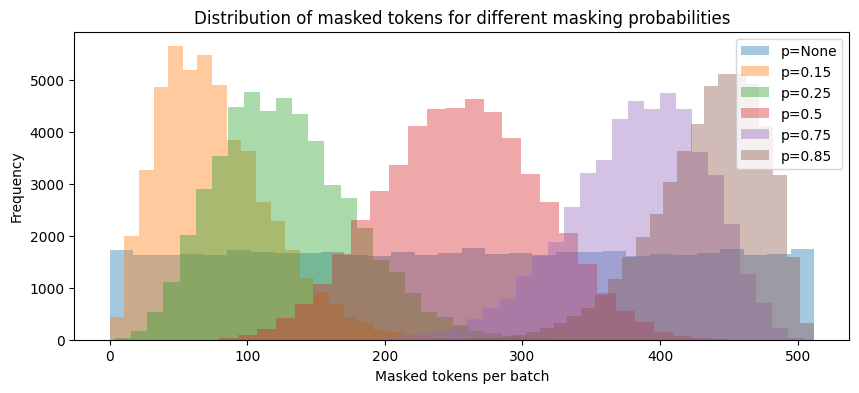

In [5]:
# histograms for each mp in one chart
plt.figure(figsize=(10, 4))
for mp, zeros in zero_counts.items():
    plt.hist(zeros, bins=30, alpha=0.4, label=f"p={mp}")

plt.xlabel("Masked tokens per batch")
plt.ylabel("Frequency")
plt.title("Distribution of masked tokens for different masking probabilities")
plt.legend()
plt.show()

In [7]:

n_batches = 5000
zero_counts_kappa = {}
kappas = [5, 10, 20, 50]
for kp in kappas:
    start_index = 0
    zeros = []
    for _ in tqdm(range(n_batches), desc="Counting zeros"):
        xb, yb = get_batch_sequential(train_data, seq_len=SEQ_LEN, batch_size=BATCH_SIZE, device=device, start_index=start_index)
        noisy_batch, _, _ = mask_tokens_batch(xb, fixed_p_mask = 0.5, kappa=kp)
        for nb in noisy_batch:
            zeros.append((nb == 0).sum().item())
        start_index += SEQ_LEN * BATCH_SIZE
    zero_counts_kappa[kp] = zeros


Counting zeros:   0%|          | 0/5000 [00:00<?, ?it/s]

Counting zeros: 100%|██████████| 5000/5000 [00:00<00:00, 7617.22it/s]


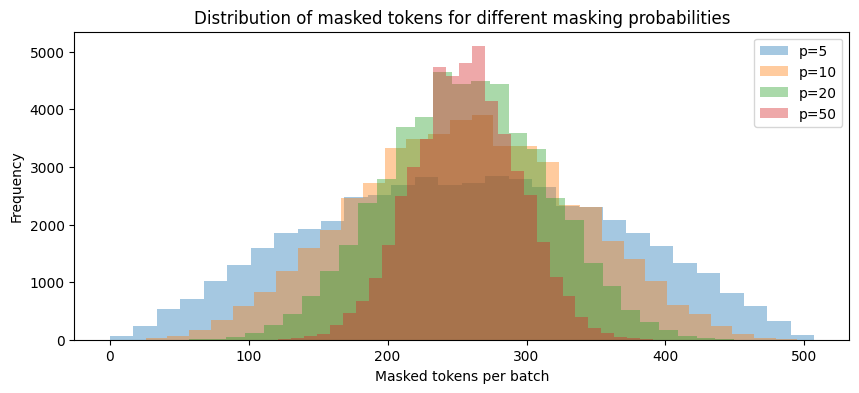

In [8]:
# histograms for each mp in one chart
plt.figure(figsize=(10, 4))
for mp, zeros in zero_counts_kappa.items():
    plt.hist(zeros, bins=30, alpha=0.4, label=f"p={mp}")

plt.xlabel("Masked tokens per batch")
plt.ylabel("Frequency")
plt.title("Distribution of masked tokens for different masking probabilities")
plt.legend()
plt.show()